In [41]:
import numpy as np
import matplotlib.pyplot as plt
from gco import pygco
import cv2

In [42]:
def load_stereo_images(image1_path, image2_path):
    img1 = cv2.imread(image1_path)[:, :, [2, 1, 0]]
    img2 = cv2.imread(image2_path)[:, :, [2, 1, 0]]
    return img1, img2

def calculate_rectification_matrices(K1, R1, T1, K2, R2, T2, disparity):
    t2 = np.dot(np.dot(np.dot(K2, R2.T), R1), np.linalg.inv(K1))
    t1 = np.dot(np.dot(K2, R2.T), (T1 - T2))

    H, W = img1.shape[0], img1.shape[1]

    hx = np.tile(np.arange(W)[:, np.newaxis], [1, H]).T.reshape(1, -1)
    hy = np.tile(np.arange(H)[:, np.newaxis], [1, W]).reshape(1, -1)
    xh = np.concatenate((hx, hy, np.ones(H * W).reshape(1, -1)), axis=0)
    hi = xh.astype(int)

    x_h_term = np.dot(t2, xh)

    if len(disparity.shape) == 2:
        h1 = np.tile(xh[:, :, np.newaxis], [1, 1, disparity.shape[1]])
        for i in range(disparity.shape[1]):
            d = disparity[:, i] * t1
            h1[:, :, i] = x_h_term + d
    elif len(disparity.shape) == 1:
        h1 = np.tile(xh[:, :, np.newaxis], [1, 1, disparity.shape[0]])
        for i in range(disparity.shape[0]):
            d = disparity[i] * t1
            h1[:, :, i] = x_h_term + d
    else:
        raise ValueError("Invalid number of dimensions for the disparity array.")

    return hi, h1


In [43]:
K1 = np.array([[1221.2270770, 0.0, 479.5000000],
                   [0.0, 1221.2270770, 269.5000000],
                   [0.0, 0.0, 1.0]])
R1 = np.eye(3)
T1 = np.array([[0.0], [0.0], [0.0]])

K2 = np.array([[1221.2270770, 0.0, 479.5000000],
                [0.0, 1221.2270770, 269.5000000],
                [0.0, 0.0, 1.0]])
R2 = np.array([[0.9998813487, 0.0148994942, 0.0039106989],
                [-0.0148907594, 0.9998865876, -0.0022532664],
                [-0.0039438279, 0.0021947658, 0.9999898146]])
T2 = np.array([[-9.9909793759], [0.2451742154], [0.1650832670]])

disparity_values = np.arange(0, 0.01, 0.01 / 65)

image1_path = 'test00.jpg'
image2_path = 'test09.jpg'
img1, img2 = load_stereo_images(image1_path, image2_path)
hi, h1 = calculate_rectification_matrices(K1, R1, T1, K2, R2, T2, disparity_values)


In [44]:
def calculate_color_distance(c1, c2):
    return (abs(int(c1[0]) - int(c2[0])) +
            abs(int(c1[1]) - int(c2[1])) +
            abs(int(c1[2]) - int(c2[2]))) / 20

def compute_smoothness_matrix(d_number):
    smooth = np.zeros((d_number, d_number))
    for i in range(d_number):
        for j in range(d_number):
            if i != j:
                smooth[i][j] = abs(i - j)
    return smooth

def compute_unary_potentials(img1, img2, hi, h1, disparity):
    H, W, d_number = img1.shape[0], img1.shape[1], len(disparity)
    unary_potentials = np.zeros((H, W, d_number))
    max_unary = 0

    for i in range(H):
        for j in range(W):
            x, y = hi[0:2, i * W + j]
            for k in range(d_number):
                x_1, y_1, z_1 = h1[:, i * W + j, k]
                x_1 = int(x_1 / z_1)
                y_1 = int(y_1 / z_1)
                if 0 <= x_1 < W and 0 <= y_1 < H:
                    unary_potentials[y, x, k] = calculate_color_distance(img1[y, x, :], img2[y_1, x_1, :])
                    max_unary = max(unary_potentials[y, x, k], max_unary)

    return unary_potentials, max_unary

def depth_estimation(img1, img2, hi, h1, disparity_values):
    if len(disparity_values.shape) == 1:
        disparity_values = disparity_values[:, np.newaxis]

    d_number = disparity_values.shape[0]

    smoothness_matrix = compute_smoothness_matrix(d_number)

    unary_potentials, max_unary = compute_unary_potentials(img1, img2, hi, h1, disparity_values)

    labels = pygco.cut_grid_graph_simple(unary_potentials, smoothness_matrix * 0.1, connect=8, n_iter=-1)
    labels = labels.reshape(img1.shape[0], img1.shape[1])

    return labels

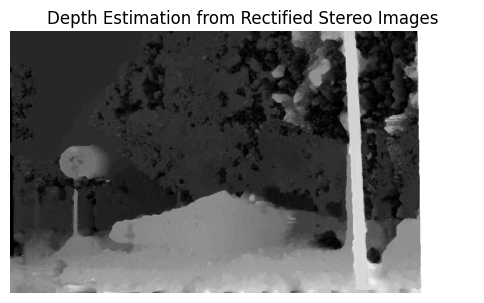

In [45]:
depth_labels = depth_estimation(img1, img2, hi, h1, disparity_values)
plt.figure(num=1, dpi=100, figsize=(6, 6))
plt.imshow(depth_labels, cmap='gray')
plt.title('Depth Estimation from Rectified Stereo Images')
plt.axis("off")
plt.show()